In [1]:
import pandas as pd 
import numpy as np
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_grades = pd.read_csv('food+establishment+grades.csv')
df_violations=pd.read_csv('food+establishment+violations.csv')

In [3]:
#drop rows where issurance data or expiration date are missing. 
df_grades['ISSDTTM'].replace(' ', np.nan, inplace=True)
df_grades['EXPDTTM'].replace(' ', np.nan, inplace=True)
df_grades.dropna(subset=['ISSDTTM','EXPDTTM'], inplace=True)

In [4]:
import datetime
#Convert the columns related with time ('RESULTDTTM', 'ISSDTTM', 'EXPDTTM') to datetime object for easier future calculations and analysis.  
df_grades['RESULTDTTM'] = df_grades['RESULTDTTM'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))
df_grades['ISSDTTM'] = df_grades['ISSDTTM'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))
df_grades['EXPDTTM'] = df_grades['EXPDTTM'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))

In [5]:
#year-based calculation, add a new column representing inspection year for future easier analysis
df_grades['RESULTY'] = df_grades['RESULTDTTM'].apply(lambda x:x.year)

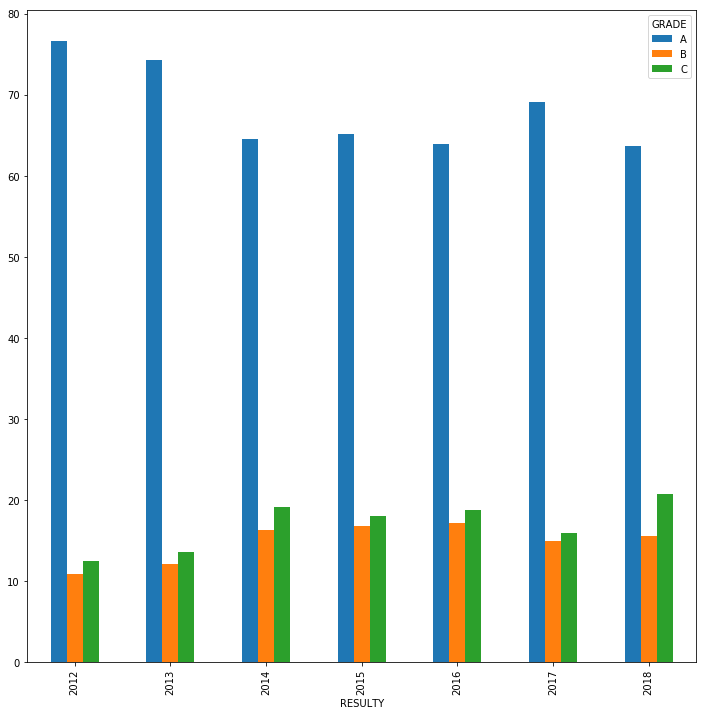

In [6]:
#use groupby to get the statistics by group
grouped_yg_total=df_grades.groupby(['RESULTY','GRADE']).size()
grouped_yg_percent = grouped_yg_total.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
grouped_yg_percent.unstack().plot(kind='bar',figsize=(12,12))

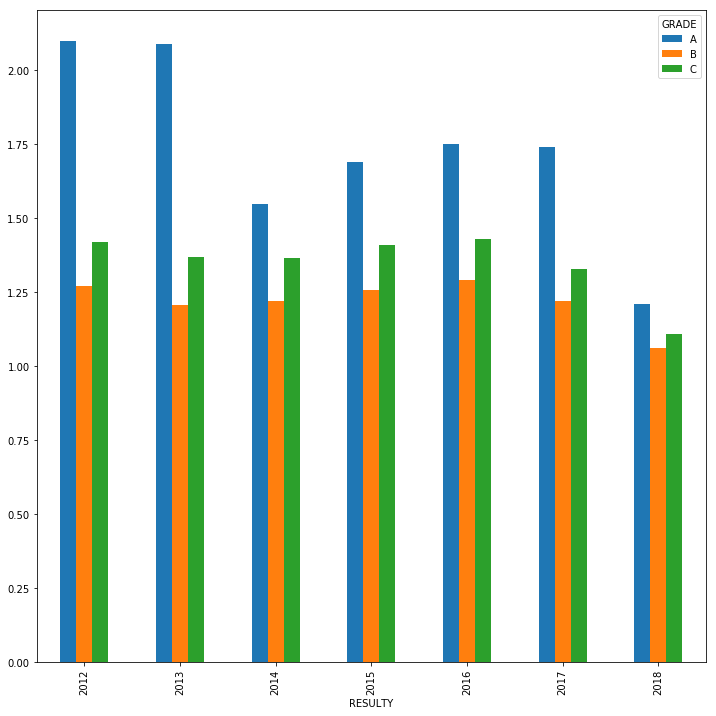

In [7]:
#get duplicates of establishment which have same grade and ID in same year
df_grades_unique=df_grades.drop_duplicates(subset=['LICENSENO', 'GRADE','RESULTY'])
grouped_yg_uniTotal=df_grades_unique.groupby(['RESULTY','GRADE']).size()
grouped_yg_total.unstack().div(grouped_yg_uniTotal.unstack(), axis=0).plot(kind='bar',figsize=(12,12))

# Problem2

In [8]:
df_violations['ISSDTTM'].replace(' ', np.nan, inplace=True)
df_violations['EXPDTTM'].replace(' ', np.nan, inplace=True)
df_violations.dropna(subset=['ISSDTTM','EXPDTTM'], inplace=True)
df_violations['RESULTDTTM'] = df_violations['RESULTDTTM'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))
df_violations['ISSDTTM'] = df_violations['ISSDTTM'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))
df_violations['EXPDTTM'] = df_violations['EXPDTTM'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %H:%M'))

In [9]:
#merge two tables
df_merge=df_violations.merge(df_grades, how='left')

In [10]:
#return a dataframe with establishments locations for later heat map
def df_map(df):
    df_merge_map=df.drop_duplicates(subset=['LOCATION']).dropna(subset=['LOCATION'])
    df_map=pd.DataFrame(df_merge_map.LOCATION.str.replace('(','').str.replace(')','').str.split(',',1).tolist(),
                                   columns = ['latitude','longitude'])
    df_map['LICENSENO']=df_merge_map['LICENSENO']
    df_map['latitude'] = df_map.latitude.astype(float)
    df_map['longitude'] = df_map.longitude.astype(float)
    return df_map

In [11]:
df_map_C=df_map(df_merge[df_merge['GRADE']=='C'])

In [12]:
#initialize m and mark every bad establishment as point in the map
m = folium.Map([42.311843000, -71.114001000])
estArr = df_map_C[['latitude', 'longitude']].as_matrix()
m.add_children(plugins.HeatMap(estArr, radius=15))
m

/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


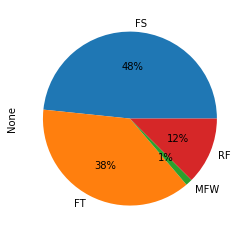

In [13]:
df_merge.groupby('LICENSECAT').size().plot.pie(autopct='%1.0f%%')

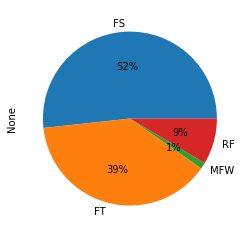

In [14]:
df_merge[df_merge['GRADE']=='C'].groupby('LICENSECAT').size().plot.pie(autopct='%1.0f%%')

# Problem 3

In [15]:
df_grades['RESULTYM'] = df_grades['RESULTDTTM'].map(lambda x: 100*x.year + x.month)

In [16]:
df_grades['count']=1

In [17]:
#add count column and use groupby to calculate the average of monthly mean
df_average_m=df_grades.groupby(['RESULTYM']).sum().reset_index()
df_average_m['average']=df_average_m['SCORE']/df_average_m['count']

In [18]:
df_average_m

,RESULTYM,LICENSENO,SUM_VIOLATIONS,SCORE,RESULTY,count,average
0,201201,27711728,9154,74646,1686056,838,89.076372
1,201202,29052498,7686,76714,1698128,844,90.893365
2,201203,33557598,9582,82118,1845004,917,89.550709
3,201204,32417700,10892,82508,1879208,934,88.338330
4,201205,39966315,11394,99106,2223260,1105,89.688688
5,201206,25692168,6627,65973,1460712,726,90.871901
6,201207,24722655,5757,61143,1346028,669,91.394619
7,201208,35560164,9169,86431,1923472,956,90.408996
8,201209,27542268,6582,65818,1456688,724,90.908840
9,201210,39095617,10223,94977,2116624,1052,90.282319


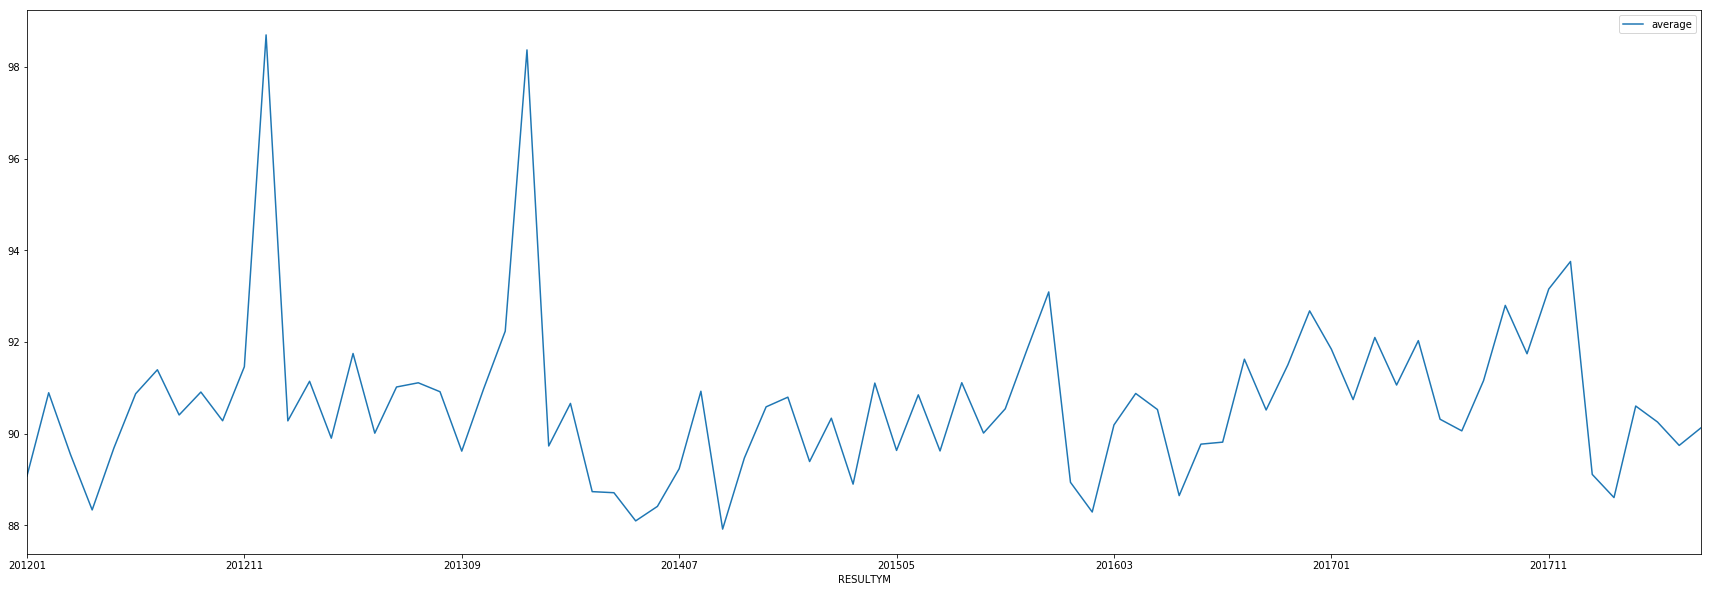

In [19]:
df_average_m['RESULTYM']=df_average_m.RESULTYM.astype(str)
df_average_m.plot(x='RESULTYM',y='average',figsize=(30,10))

In [20]:
df_grades

,LICENSENO,ISSDTTM,EXPDTTM,LICSTATUS,LICENSECAT,DESCRIPT,RESULT,RESULTDTTM,SUM_VIOLATIONS,SCORE,GRADE,RESULTY,RESULTYM,count
0,77958,2012-03-14 09:17:00,2012-12-31 23:59:00,Inactive,FT,Eating & Drinking w/ Take Out,HE_Pass,2012-01-03 07:26:00,0,100,A,2012,201201,1
1,74470,2012-02-01 12:29:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 09:42:00,6,94,A,2012,201201,1
2,18086,2011-12-27 12:46:00,2011-12-31 23:59:00,Inactive,RF,Retail Food,HE_Fail,2012-01-03 10:06:00,6,94,A,2012,201201,1
3,77035,2012-01-26 11:01:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_FailExt,2012-01-03 10:07:00,12,88,B,2012,201201,1
4,20285,2012-02-24 14:46:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 10:32:00,2,98,A,2012,201201,1
5,18111,2012-05-11 10:10:00,2012-12-31 23:59:00,Inactive,RF,Retail Food,HE_Filed,2012-01-03 10:37:00,2,98,A,2012,201201,1
6,76109,2012-07-19 12:58:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_Fail,2012-01-03 10:44:00,16,84,B,2012,201201,1
7,18870,2012-03-15 10:19:00,2018-12-31 23:59:00,Active,FT,Eating & Drinking w/ Take Out,HE_Pass,2012-01-03 10:46:00,0,100,A,2012,201201,1
8,25877,2012-01-03 14:09:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Fail,2012-01-03 10:47:00,32,68,C,2012,201201,1
9,19921,2012-03-06 09:35:00,2018-12-31 23:59:00,Active,FT,Eating & Drinking w/ Take Out,HE_Filed,2012-01-03 10:48:00,4,96,A,2012,201201,1


In [21]:
df_violations

,LICENSENO,ISSDTTM,EXPDTTM,LICSTATUS,LICENSECAT,DESCRIPT,RESULT,RESULTDTTM,VIOLATION,VIOLLEVEL,VIOLDESC,VIOLDTTM,VIOLSTATUS,PROPERTY_ID,LOCATION
0,77958,2012-03-14 09:17:00,2012-12-31 23:59:00,Inactive,FT,Eating & Drinking w/ Take Out,HE_Pass,2012-01-03 07:26:00,NaN,NaN,NaN,,NaN,155968.0,"(42.355863000, -71.061898000)"
1,74470,2012-02-01 12:29:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 09:42:00,15-4-202.16,*,Non-Food Contact Surfaces,1/3/2012 9:42,Fail,48511.0,"(42.278028000, -71.066046000)"
2,74470,2012-02-01 12:29:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 09:42:00,36-6-501.11-.12,*,Improper Maintenance of Floors,1/3/2012 9:42,Fail,48511.0,"(42.278028000, -71.066046000)"
3,74470,2012-02-01 12:29:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 09:42:00,37-6-501.11-.12,*,Improper Maintenance of Walls/Ceilings,1/3/2012 9:42,Fail,48511.0,"(42.278028000, -71.066046000)"
4,18086,2011-12-27 12:46:00,2011-12-31 23:59:00,Inactive,RF,Retail Food,HE_Fail,2012-01-03 10:06:00,23-4-602.13,*,Non-Food Contact Surfaces Clean,1/3/2012 10:06,Fail,14788.0,"(42.382370000, -71.018390000)"
5,18086,2011-12-27 12:46:00,2011-12-31 23:59:00,Inactive,RF,Retail Food,HE_Fail,2012-01-03 10:06:00,36-6-201.11,*,Floors Designed Constructed Installed,1/3/2012 10:06,Fail,14788.0,"(42.382370000, -71.018390000)"
6,18086,2011-12-27 12:46:00,2011-12-31 23:59:00,Inactive,RF,Retail Food,HE_Fail,2012-01-03 10:06:00,42-6-501.113/.114,*,Premises Maintained,1/3/2012 10:06,Fail,14788.0,"(42.382370000, -71.018390000)"
7,77035,2012-01-26 11:01:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_FailExt,2012-01-03 10:07:00,15-4-202.16,*,Non-Food Contact Surfaces,1/3/2012 10:07,Fail,156956.0,"(42.330463000, -71.067234000)"
8,77035,2012-01-26 11:01:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_FailExt,2012-01-03 10:07:00,23-4-602.13,*,Non-Food Contact Surfaces Clean,1/3/2012 10:07,Fail,156956.0,"(42.330463000, -71.067234000)"
9,77035,2012-01-26 11:01:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_FailExt,2012-01-03 10:07:00,29-5-201/02.11,*,Installed and Maintained,1/3/2012 10:07,Fail,156956.0,"(42.330463000, -71.067234000)"


In [22]:
df_merge

,LICENSENO,ISSDTTM,EXPDTTM,LICSTATUS,LICENSECAT,DESCRIPT,RESULT,RESULTDTTM,VIOLATION,VIOLLEVEL,VIOLDESC,VIOLDTTM,VIOLSTATUS,PROPERTY_ID,LOCATION,SUM_VIOLATIONS,SCORE,GRADE,RESULTY
0,77958,2012-03-14 09:17:00,2012-12-31 23:59:00,Inactive,FT,Eating & Drinking w/ Take Out,HE_Pass,2012-01-03 07:26:00,NaN,NaN,NaN,,NaN,155968.0,"(42.355863000, -71.061898000)",0.0,100.0,A,2012.0
1,74470,2012-02-01 12:29:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 09:42:00,15-4-202.16,*,Non-Food Contact Surfaces,1/3/2012 9:42,Fail,48511.0,"(42.278028000, -71.066046000)",6.0,94.0,A,2012.0
2,74470,2012-02-01 12:29:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 09:42:00,36-6-501.11-.12,*,Improper Maintenance of Floors,1/3/2012 9:42,Fail,48511.0,"(42.278028000, -71.066046000)",6.0,94.0,A,2012.0
3,74470,2012-02-01 12:29:00,2018-12-31 23:59:00,Active,FS,Eating & Drinking,HE_Filed,2012-01-03 09:42:00,37-6-501.11-.12,*,Improper Maintenance of Walls/Ceilings,1/3/2012 9:42,Fail,48511.0,"(42.278028000, -71.066046000)",6.0,94.0,A,2012.0
4,18086,2011-12-27 12:46:00,2011-12-31 23:59:00,Inactive,RF,Retail Food,HE_Fail,2012-01-03 10:06:00,23-4-602.13,*,Non-Food Contact Surfaces Clean,1/3/2012 10:06,Fail,14788.0,"(42.382370000, -71.018390000)",6.0,94.0,A,2012.0
5,18086,2011-12-27 12:46:00,2011-12-31 23:59:00,Inactive,RF,Retail Food,HE_Fail,2012-01-03 10:06:00,36-6-201.11,*,Floors Designed Constructed Installed,1/3/2012 10:06,Fail,14788.0,"(42.382370000, -71.018390000)",6.0,94.0,A,2012.0
6,18086,2011-12-27 12:46:00,2011-12-31 23:59:00,Inactive,RF,Retail Food,HE_Fail,2012-01-03 10:06:00,42-6-501.113/.114,*,Premises Maintained,1/3/2012 10:06,Fail,14788.0,"(42.382370000, -71.018390000)",6.0,94.0,A,2012.0
7,77035,2012-01-26 11:01:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_FailExt,2012-01-03 10:07:00,15-4-202.16,*,Non-Food Contact Surfaces,1/3/2012 10:07,Fail,156956.0,"(42.330463000, -71.067234000)",12.0,88.0,B,2012.0
8,77035,2012-01-26 11:01:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_FailExt,2012-01-03 10:07:00,23-4-602.13,*,Non-Food Contact Surfaces Clean,1/3/2012 10:07,Fail,156956.0,"(42.330463000, -71.067234000)",12.0,88.0,B,2012.0
9,77035,2012-01-26 11:01:00,2018-12-31 23:59:00,Active,RF,Retail Food,HE_FailExt,2012-01-03 10:07:00,29-5-201/02.11,*,Installed and Maintained,1/3/2012 10:07,Fail,156956.0,"(42.330463000, -71.067234000)",12.0,88.0,B,2012.0
